## Connect to the Google Drive

#Importing the required libraries

In [ ]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from scipy import stats
import os
import math

#Loading and preprocessing the data

Copying the data from google drive for easier access to the data

Reading and Processing Data with sliding window approach

In [ ]:
# Function for splitting data into time windows and time steps
Wind = 1.8 # second
Xfreq = 0.025 # second
Yfreq = 0.1 # second

def LoadData(path):

  FeatureNumber = 6
  CategoryNumber = 4

  Allfiles = os.listdir(path)

  filenamesx = list()
  filenamesy = list()

  # Finding x and y data files
  for i in range(0,np.size(Allfiles)):
    file = Allfiles[i].split('__')
    if file[-1] == 'x.csv':
      filenamesx.append(Allfiles[i])
      for j in range(0,np.size(Allfiles)):
        file2 = Allfiles[j].split('__')
        if file2[-1] == 'y.csv' and file2[0] == file[0]:
          filenamesy.append(Allfiles[j])

  loadedx = np.empty((0, int (Wind/Xfreq), FeatureNumber), dtype=float)
  loadedy = np.empty((0, CategoryNumber), dtype=float)

  for i in range(0,np.size(filenamesx)):

    # split X data into time windows and time steps
    name = filenamesx[i]
    DataX = read_csv(path + name, header=None, sep=',')
    WindSteps = int (Wind/Xfreq)
    NumWind = int( np.size(DataX,0) /  WindSteps)

    DX = []
    slider = 3
    for m in range(0+1,slider+1):
      n =math.floor((WindSteps-1)/m)
      DX = DataX[n:(NumWind-1)*WindSteps+n]
      DX = np.array(np.array_split(DX.values, (NumWind-1)))
      loadedx = np.append(loadedx, DX, axis=0)

    DataX = DataX[0:NumWind*WindSteps]
    DataX = np.array(np.array_split(DataX.values, NumWind))
    loadedx = np.append(loadedx, DataX, axis=0)

    # split Y data into time windows and time steps + one-hot coding
    name = filenamesy[i]
    DataY = read_csv(path + name, header=None, sep=',')
    DataY = np.append(0,DataY)
    WindSteps = int (Wind/Yfreq)

    DY = []
    for m in range(0+1,slider+1):
      n =math.floor((WindSteps-1)/m)
      DY = DataY[n:(NumWind-1)*WindSteps+n]
      DY= np.array_split(DY, (NumWind-1))
      mode_info  = stats.mode(DY, axis = 1)
      DY = mode_info[0].reshape(np.size(DY,0),1)
      DY = to_categorical(DY)
      loadedy = np.append(loadedy, DY, axis=0)

    DataY = DataY[0:NumWind*WindSteps]
    DataY= np.array_split(DataY, NumWind)
    mode_info  = stats.mode(DataY, axis = 1)
    DataY = mode_info[0].reshape(np.size(DataY,0),1)
    DataY = to_categorical(DataY)
    loadedy = np.append(loadedy, DataY, axis=0)


  return loadedx, loadedy

#trainx, trainy = LoadData ('/content/TrainingData/')
trainx, trainy = LoadData ('/content/drive/My Drive/Colab Notebooks/TrDataset/TrainingData/')

print(np.shape(trainx))
print(np.shape(trainy))


Split the training data into training and validation set. The validation set assigned to be 20% of the entire training set.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.2, random_state=42)

Show the dimensions of the training and validation sets.

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

#Fixing the data imbalance

Show the label number in both validation and training sets.

In [ ]:
print("Training set")
print("label 0 =" +str(sum(y_train[:,0])) + " || label 1 =" +str(sum(y_train[:,1])) + " || label 2 =" +str(sum(y_train[:,2])) + " || label 3 =" +str(sum(y_train[:,3])))
print("minimum accuracy due to imblance = " + str(max(sum(y_train[:,0])/y_train.shape[0],sum(y_train[:,1])/y_train.shape[0],sum(y_train[:,2])/y_train.shape[0],sum(y_train[:,3])/y_train.shape[0])))

print("=================================")
print("Validation set")
print("label 0 =" +str(sum(y_val[:,0])) + " || label 1 =" +str(sum(y_val[:,1])) + " || label 2 =" +str(sum(y_val[:,2])) + " || label 3 =" +str(sum(y_val[:,3])))


Training set
label 0 =44737.0 || label 1 =2439.0 || label 2 =3177.0 || label 3 =9158.0
minimum accuracy due to imblance = 0.7517433751743375
Validation set
label 0 =11208.0 || label 1 =587.0 || label 2 =822.0 || label 3 =2261.0


Balance the training data using upsampling the data.

In [ ]:
def Balance(augmentation, x_data, y_data, limit = 250000):

  i_class0 = np.where(y_data[:,0] == 1)[0]
  i_class1 = np.where(y_data[:,1] == 1)[0]
  i_class2 = np.where(y_data[:,2] == 1)[0]
  i_class3 = np.where(y_data[:,3] == 1)[0]

  n_class0 = len(i_class0)
  n_class1 = len(i_class1)
  n_class2 = len(i_class2)
  n_class3 = len(i_class3)

  train_x_us = []
  train_y_us = []

  if(augmentation == True):
    if (n_class0 > limit):
      i_class0 = np.random.choice(i_class0, size=limit, replace=False)
      n_class0 = len(i_class0)

    i_class1_upsampled = np.random.choice(i_class1, size=n_class0-n_class1, replace=True)
    i_class2_upsampled = np.random.choice(i_class2, size=n_class0-n_class2, replace=True)
    i_class3_upsampled = np.random.choice(i_class3, size=n_class0-n_class3, replace=True)

    noise1 = np.random.normal(0,0.1,(n_class0-n_class1,int (Wind/Xfreq),6))
    noise2 = np.random.normal(0,0.1,(n_class0-n_class2,int (Wind/Xfreq),6))
    noise3 = np.random.normal(0,0.1,(n_class0-n_class3,int (Wind/Xfreq),6))

    train_x_us = np.concatenate((x_data[i_class0,:,:],x_data[i_class1,:,:],x_data[i_class2,:,:],x_data[i_class3,:,:],x_data[i_class1_upsampled,:,:]+noise1,x_data[i_class2_upsampled,:,:]+noise2,x_data[i_class3_upsampled,:,:]+noise3))
    train_y_us = np.concatenate((y_data[i_class0,:],y_data[i_class1,:],y_data[i_class2,:],y_data[i_class3,:],y_data[i_class1_upsampled,:],y_data[i_class2_upsampled,:],y_data[i_class3_upsampled,:]))

    shuffler = np.random.permutation(len(train_x_us))
    train_x_us = train_x_us[shuffler]
    train_y_us = train_y_us[shuffler]

  if(augmentation == False):
    if (n_class0 > limit):
      i_class0 = np.random.choice(i_class0, size=limit, replace=False)
      n_class0 = len(i_class0)

    i_class1_upsampled = np.random.choice(i_class1, size=n_class0-n_class1, replace=True)
    i_class2_upsampled = np.random.choice(i_class2, size=n_class0-n_class2, replace=True)
    i_class3_upsampled = np.random.choice(i_class3, size=n_class0-n_class3, replace=True)

    train_x_us = np.concatenate((x_data[i_class0,:,:],x_data[i_class1,:,:],x_data[i_class2,:,:],x_data[i_class3,:,:],x_data[i_class1_upsampled,:,:],x_data[i_class2_upsampled,:,:],x_data[i_class3_upsampled,:,:]))
    train_y_us = np.concatenate((y_data[i_class0,:],y_data[i_class1,:],y_data[i_class2,:],y_data[i_class3,:],y_data[i_class1_upsampled,:],y_data[i_class2_upsampled,:],y_data[i_class3_upsampled,:]))

    shuffler = np.random.permutation(len(train_x_us))
    train_x_us = train_x_us[shuffler]
    train_y_us = train_y_us[shuffler]

  return train_x_us, train_y_us

Show the label number in both upsampled validation and training sets.

In [ ]:
augmentation = False
train_x_us, train_y_us = Balance(augmentation, x_train, y_train )

augmentation = False
val_x_us, val_y_us = Balance(augmentation, x_val, y_val )

print("Upsamplesd training set")
print("label 0 =" +str(sum(train_y_us[:,0])) + " || label 1 =" +str(sum(train_y_us[:,1])) + " || label 2 =" +str(sum(train_y_us[:,2])) + " || label 3 =" +str(sum(train_y_us[:,3])))
print("minimum accuracy = " + str(max(sum(train_y_us[:,0])/train_y_us.shape[0],sum(train_y_us[:,1])/train_y_us.shape[0],sum(train_y_us[:,2])/train_y_us.shape[0],sum(train_y_us[:,3])/train_y_us.shape[0])))

print("=================================")
print("Upsamplesd validation set")
print("label 0 =" +str(sum(val_y_us[:,0])) + " || label 1 =" +str(sum(val_y_us[:,1])) + " || label 2 =" +str(sum(val_y_us[:,2])) + " || label 3 =" +str(sum(val_y_us[:,3])))
print("=================================")
print("Data shape")
print(train_y_us.shape)
print(val_y_us.shape)

Upsamplesd training set
label 0 =44737.0 || label 1 =44737.0 || label 2 =44737.0 || label 3 =44737.0
minimum accuracy = 0.25
Upsamplesd validation set
label 0 =11208.0 || label 1 =11208.0 || label 2 =11208.0 || label 3 =11208.0
Data shape
(178948, 4)
(44832, 4)


#Training the model with batch generator

In [ ]:
class KerasBatchGenerator(object):

    def __init__(self, x,y, batch_size,shapeX, shapeY):
        self.x = x
        self.y = y
        self.shapeX = shapeX
        self.shapeY = shapeY
        self.batch_size = batch_size
        self.current_idx = 0

    def generate(self):
        x = np.zeros((self.batch_size, self.shapeX[0],self.shapeX[1]))
        y = np.zeros((self.batch_size, self.shapeY))

        while True:
            for i in range(int(self.batch_size/4)):
                if self.current_idx >= len(self.x):
                    # reset the index back to the start of the data set
                    self.current_idx = 0

                noise1 = np.random.normal(0,0.1,(1,int (Wind/Xfreq),6))
                noise2 = np.random.normal(0,0.05,(1,int (Wind/Xfreq),6))
                noise3 = np.random.normal(0,0.01,(1,int (Wind/Xfreq),6))

                x[4*i,:, :] = self.x[self.current_idx,:,:]
                x[4*i+1,:, :] = self.x[self.current_idx,:,:] + noise1
                x[4*i+2,:, :] = self.x[self.current_idx,:,:] + noise2
                x[4*i+3,:, :] = self.x[self.current_idx,:,:] + noise3

                y[4*i, :] = self.y[self.current_idx,:]
                y[4*i+1, :] = self.y[self.current_idx,:]
                y[4*i+2, :] = self.y[self.current_idx,:]
                y[4*i+3, :] = self.y[self.current_idx,:]

                self.current_idx += 1
                #print(self.current_idx)
            yield x, y

In [ ]:
class KerasBatchGenerator_validation(object):

    def __init__(self, x,y, batch_size,shapeX, shapeY):
        self.x = x
        self.y = y
        self.shapeX = shapeX
        self.shapeY = shapeY
        self.batch_size = batch_size
        self.current_idx = 0

    def generate(self):
        x = np.zeros((self.batch_size, self.shapeX[0],self.shapeX[1]))
        y = np.zeros((self.batch_size, self.shapeY))

        while True:
            for i in range(self.batch_size):
                if self.current_idx >= len(self.x):
                    # reset the index back to the start of the data set
                    self.current_idx = 0


                x[i,:, :] = self.x[self.current_idx,:,:]

                y[i, :] = self.y[self.current_idx,:]
                self.current_idx += 1
                #print(self.current_idx)
            yield x, y

Plot the model accuracy chart

In [ ]:
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

#Hyperparameter optimization

In [ ]:
batch_size =256
dropout = [0.8, 0.85, 0.9]
hidden_size = [200, 250, 300]

for d in dropout:
    for h in hidden_size:
        print("dropout = ", d)
        print("hidden_size = ", h)
        train_data_generator = KerasBatchGenerator(train_x_us, train_y_us, batch_size,(int (Wind/Xfreq),6),4)
        valid_data_generator = KerasBatchGenerator_validation(val_x_us, val_y_us, batch_size,(int (Wind/Xfreq),6),4)

        model_BiLSTM2 = Sequential()
        model_BiLSTM2.add(Bidirectional(LSTM(units=h, input_shape=(int (Wind/Xfreq), 6))))
        model_BiLSTM2.add(Dropout(d))
        model_BiLSTM2.add(BatchNormalization())
        model_BiLSTM2.add(Dense(60, activation="softmax"))
        model_BiLSTM2.add(Dropout(d))
        model_BiLSTM2.add(BatchNormalization())
        model_BiLSTM2.add(Dense(4, activation="softmax"))
        model_BiLSTM2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

        history_BiLSTM2 = model_BiLSTM2.fit_generator(train_data_generator.generate(), len(train_x_us)//(batch_size),epochs=1,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(val_x_us)//(batch_size))


dropout =  0.8
hidden_size =  200
Instructions for updating:
Please use Model.fit, which supports generators.
699/699 [==============================] - 21s 30ms/step - loss: 0.7654 - categorical_accuracy: 0.7048 - val_loss: 0.3095 - val_categorical_accuracy: 0.9000
dropout =  0.8
hidden_size =  250
699/699 [==============================] - 27s 39ms/step - loss: 0.7560 - categorical_accuracy: 0.7101 - val_loss: 0.3527 - val_categorical_accuracy: 0.8901
dropout =  0.8
hidden_size =  300
699/699 [==============================] - 35s 50ms/step - loss: 0.7936 - categorical_accuracy: 0.6730 - val_loss: 0.4316 - val_categorical_accuracy: 0.8375
dropout =  0.85
hidden_size =  200
699/699 [==============================] - 22s 31ms/step - loss: 1.0816 - categorical_accuracy: 0.5328 - val_loss: 0.8543 - val_categorical_accuracy: 0.6458
dropout =  0.85
hidden_size =  250
699/699 [==============================] - 28s 40ms/step - loss: 0.9085 - categorical_accuracy: 0.6128 - val_loss: 0.4909 - 

# Train model with the best parameter

Epoch 1/10
699/699 [==============================] - 27s 39ms/step - loss: 0.8155 - categorical_accuracy: 0.6519 - val_loss: 0.4858 - val_categorical_accuracy: 0.7732
Epoch 2/10
699/699 [==============================] - 27s 38ms/step - loss: 0.5337 - categorical_accuracy: 0.7547 - val_loss: 0.3830 - val_categorical_accuracy: 0.8533
Epoch 3/10
699/699 [==============================] - 27s 39ms/step - loss: 0.4208 - categorical_accuracy: 0.8582 - val_loss: 0.2814 - val_categorical_accuracy: 0.9242
Epoch 4/10
699/699 [==============================] - 27s 38ms/step - loss: 0.3546 - categorical_accuracy: 0.8878 - val_loss: 0.2328 - val_categorical_accuracy: 0.9227
Epoch 5/10
699/699 [==============================] - 27s 38ms/step - loss: 0.3196 - categorical_accuracy: 0.9017 - val_loss: 0.1755 - val_categorical_accuracy: 0.9389
Epoch 6/10
699/699 [==============================] - 27s 38ms/step - loss: 0.2929 - categorical_accuracy: 0.9116 - val_loss: 0.1979 - val_categorical_accuracy:

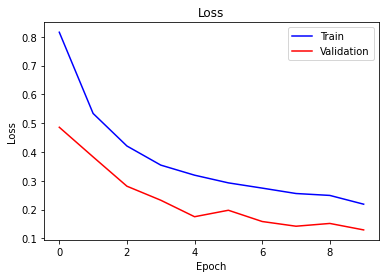

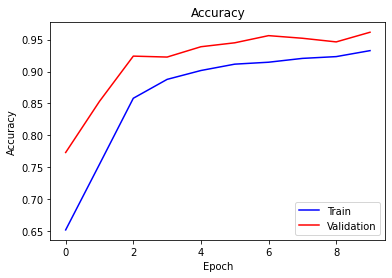

In [ ]:
# This is the number of hidden units in the RNN layer
hidden_size = 250
rate_dropout = 0.8
batch_size =256

train_data_generator = KerasBatchGenerator(train_x_us, train_y_us, batch_size,(int (Wind/Xfreq),6),4)
valid_data_generator = KerasBatchGenerator_validation(val_x_us, val_y_us, batch_size,(int (Wind/Xfreq),6),4)

model_BiLSTM2 = Sequential()
model_BiLSTM2.add(Bidirectional(LSTM(units=hidden_size, input_shape=(int (Wind/Xfreq), 6))))
model_BiLSTM2.add(Dropout(rate_dropout))
model_BiLSTM2.add(BatchNormalization())
model_BiLSTM2.add(Dense(60, activation="softmax"))
model_BiLSTM2.add(Dropout(rate_dropout))
model_BiLSTM2.add(BatchNormalization())
model_BiLSTM2.add(Dense(4, activation="softmax"))

model_BiLSTM2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

history_BiLSTM2 = model_BiLSTM2.fit_generator(train_data_generator.generate(), len(train_x_us)//(batch_size),epochs=10,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(val_x_us)//(batch_size))

plot_history(history_BiLSTM2)

Verify the final model accuracy and calculate other performance measures

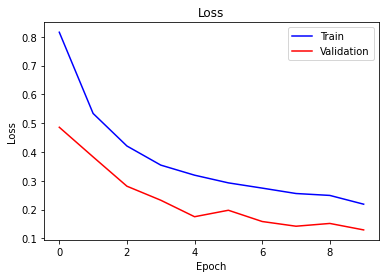

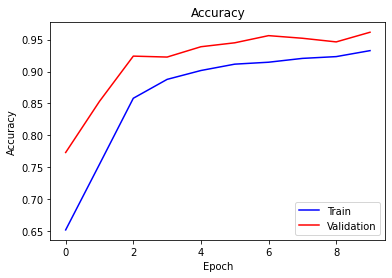

Accuracy_keras: 0.961635
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy_Manual: 0.961635
precision: 
[0.91955544 0.99064664 0.98568873 0.95141122]
0.9618255067496355
Recall:
[0.93013919 0.98278016 0.98322627 0.95039258]
0.9616345467523197
F1
[0.92481703 0.98669772 0.98445596 0.95090162]
0.9617180840273963

confusion matrix:

[[10425    94   145   544]
 [  193 11015     0     0]
 [  188     0 11020     0]
 [  531    10    15 10652]]



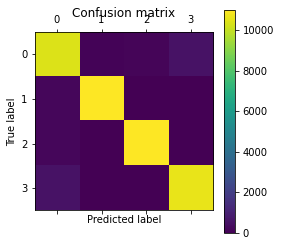

In [ ]:
import sklearn.metrics as skm

plot_history(history_BiLSTM2)

_, train_acc = model_BiLSTM2.evaluate(val_x_us, val_y_us, verbose=0)
print('Accuracy_keras: %f' % train_acc)

# predict probabilities and predictions
yhat_classes = model_BiLSTM2.predict_classes(val_x_us, verbose=0)
tmp = [np.where(r==1)[0][0] for r in val_y_us]
#print(tmp)

# accuracy
accuracy = skm.accuracy_score(tmp, yhat_classes)
print('Accuracy_Manual: %f' % accuracy)

# precision
precision = skm.precision_score(tmp, yhat_classes, average=None)
print('precision: ')
print(precision)
precision = skm.precision_score(tmp, yhat_classes, average='weighted')
print(precision)

# recall
recall = skm.recall_score(tmp, yhat_classes, average=None)
print('Recall:')
print(recall)
recall = skm.recall_score(tmp, yhat_classes, average='weighted')
print(recall)

# f1
f1 = skm.f1_score(tmp, yhat_classes, average=None)
print('F1')
print(f1)
f1 = skm.f1_score(tmp, yhat_classes, average='weighted')
print(f1)


# confusion matrix
matrix = skm.confusion_matrix(tmp, yhat_classes)
print('\nconfusion matrix:\n')
print(matrix)
print()
plt.matshow(matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
augmentation = False
trainx_us, trainy_us = Balance(augmentation, trainx, trainy )

# Training of the final model

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

hidden_size = 250
rate_dropout = 0.8
batch_size =256

train_data_generator = KerasBatchGenerator(trainx_us, trainy_us, batch_size,(int (Wind/Xfreq),6),4)


model_BiLSTM3 = Sequential()
model_BiLSTM3.add(Bidirectional(LSTM(units=hidden_size, input_shape=(int (Wind/Xfreq), 6))))
model_BiLSTM3.add(Dropout(rate_dropout))
model_BiLSTM3.add(BatchNormalization())
model_BiLSTM3.add(Dense(60, activation="softmax"))
model_BiLSTM3.add(Dropout(rate_dropout))
model_BiLSTM3.add(BatchNormalization())
model_BiLSTM3.add(Dense(4, activation="softmax"))
model_BiLSTM3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
history_BiLSTM3 = model_BiLSTM3.fit_generator(train_data_generator.generate(), len(trainx_us)//(batch_size),epochs=10)

# Save the model
filepath = '/content/drive/My Drive/Colab Notebooks/TrDataset/'
#filepath = '/content/'
save_model(model_BiLSTM3, filepath)

Epoch 1/5
3906/3906 [==============================] - 141s 36ms/step - loss: 0.4274 - categorical_accuracy: 0.8393
Epoch 2/5
3906/3906 [==============================] - 142s 36ms/step - loss: 0.2161 - categorical_accuracy: 0.9292
Epoch 3/5
3906/3906 [==============================] - 142s 36ms/step - loss: 0.1635 - categorical_accuracy: 0.9489
Epoch 4/5
3906/3906 [==============================] - 142s 36ms/step - loss: 0.1213 - categorical_accuracy: 0.9647
Epoch 5/5
3906/3906 [==============================] - 142s 36ms/step - loss: 0.1009 - categorical_accuracy: 0.9706
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/assets


Store the prediction for the test dataset

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
import pandas as pd

# Load a single x and save the corresponding file
def LoadDataX(path, name):

  FeatureNumber = 6
  Ystart = 0.02 #start time of Y

  loadedx = np.empty((0, int (Wind/Xfreq), FeatureNumber), dtype=float)

  # split X data into time windows and time steps
  DataX = read_csv(path + name, header=None, sep=',')
  WindSteps = int (Wind/Xfreq)
  NumWind = int( np.size(DataX,0) /  WindSteps)
  DataX = DataX[0:NumWind*WindSteps]
  DataX = np.array(np.array_split(DataX.values, NumWind))

  loadedx = np.array(np.append(loadedx, DataX, axis=0))

  return loadedx

# Predict Y categories
def PredictY(DataY_time, DataX, model):

  predictions = model.predict(DataX)
  classes = np.argmax(predictions, axis = 1)
  Output = np.zeros(np.size(DataY_time,0))

  for i in range(0, np.size(DataY_time,0)-1):
    time = DataY_time[i]
    Row = int(time/Wind)
    Label = 0

    if Row <= np.size(DataX,0)-1:
      Label = classes[Row]

    Output[i] = Label

  return Output

def LoadDataY(path, name):
  DataY = read_csv(path + name, header=None, sep=',')
  return np.array(DataY)

PredictionModel = model_BiLSTM3
datapath = '/content/TestData/'
predictionpath = '/content/'
Allfiles = os.listdir(datapath)

for i in range(0, np.size(Allfiles)):
  file = Allfiles[i].split('__')
  if file[-1] == 'x.csv':
    dataX = LoadDataX(datapath, Allfiles[i])
    dataY_time = LoadDataY(datapath, file[0]+'__'+'y_time.csv')
    output = PredictY(dataY_time, dataX, PredictionModel)
    pd.DataFrame(output).to_csv(predictionpath + file[0]+'__'+'y_prediction.csv', header=None, index=None)